In [1]:
import os
print(f"Current Directory: {os.getcwd()}")
os.chdir("..")
print(f"New Directory: {os.getcwd()}")

Current Directory: c:\Users\mattc\Documents\DL-reservoir-modeling\experiments
New Directory: c:\Users\mattc\Documents\DL-reservoir-modeling


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from math import floor
import os
import copy
from scipy import stats
from scipy.stats import theilslopes
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
import seaborn as sns

from src.data.data_processing import *
from src.data.data_fetching import *
from src.models.model_zoo import *
from src.models.predict_model import *
from src.models.train_model import *
from src.models.hyperparameter_tuning import *
from src.models.analyze_lstm_cell import *

# Evaluate Training on Individual ResOps Reservoirs

In [3]:
# Read R2 scores from training individual ResOPS reservoirs
r2_scores_df = pd.read_csv('report/results/resops_training/resops_individual_r2.csv', index_col=0)
r2_scores_df.index = r2_scores_df.index.astype(str) # change index type to str
r2_scores_df

,train,val,test
1754,0.616776,0.542443,0.397781
780,0.812543,0.640911,0.261094
1756,0.640635,0.485420,0.625418
393,0.764591,0.675054,0.726631
297,0.205251,0.155093,0.151003
...,...,...,...
753,0.388972,0.030416,0.303888
505,0.384544,0.548749,0.400114
7318,0.959340,0.952557,0.929671
1776,0.872272,0.737064,0.697465


In [4]:
# Compare with benchmark scores
r2_scores_lstm = r2_scores_df.copy()
r2_scores_lstm.index = r2_scores_lstm.index.astype(int)
r2_scores_lstm_storage = pd.read_csv('report/results/resops_training/resops_benchmark_lstm_w_storage_r2.csv', index_col=0)
r2_scores_linear = pd.read_csv('report/results/resops_training/resops_benchmark_linear_r2.csv', index_col=0)
r2_scores_rf = pd.read_csv('report/results/resops_training/resops_benchmark_rf_r2.csv', index_col=0)
r2_scores_rule_based = pd.read_csv('report/results/resops_training/resops_benchmark_rule_based_r2.csv', index_col=0)

# Convert to long format
r2_scores_lstm = r2_scores_lstm.melt(value_vars=['train', 'val', 'test'])
r2_scores_lstm_storage = r2_scores_lstm_storage.melt(value_vars=['train', 'val', 'test'])
r2_scores_linear = r2_scores_linear.melt(value_vars=['train', 'val', 'test'])
r2_scores_rf = r2_scores_rf.melt(value_vars=['train', 'val', 'test'])
r2_scores_rule_based = r2_scores_rule_based.melt(value_vars=['train', 'val', 'test'])

# Add model type
r2_scores_lstm['Model'] = 'LSTM Model 1'
r2_scores_lstm_storage['Model'] = 'LSTM Model 1-S'
r2_scores_linear['Model'] = 'Linear Model-S'
r2_scores_rf['Model'] = 'Random Forest Model-S'
r2_scores_rule_based['Model'] = 'Rule-Based Model'

# Concat
r2_scores_benchmark = pd.concat([r2_scores_lstm, r2_scores_lstm_storage, r2_scores_rf, r2_scores_linear, r2_scores_rule_based], axis=0)
r2_scores_benchmark

,variable,value,Model
0,train,0.616776,LSTM Model 1
1,train,0.812543,LSTM Model 1
2,train,0.640635,LSTM Model 1
3,train,0.764591,LSTM Model 1
4,train,0.205251,LSTM Model 1
...,...,...,...
343,test,-0.331606,Rule-Based Model
344,test,0.234995,Rule-Based Model
345,test,0.360336,Rule-Based Model
346,test,0.417658,Rule-Based Model


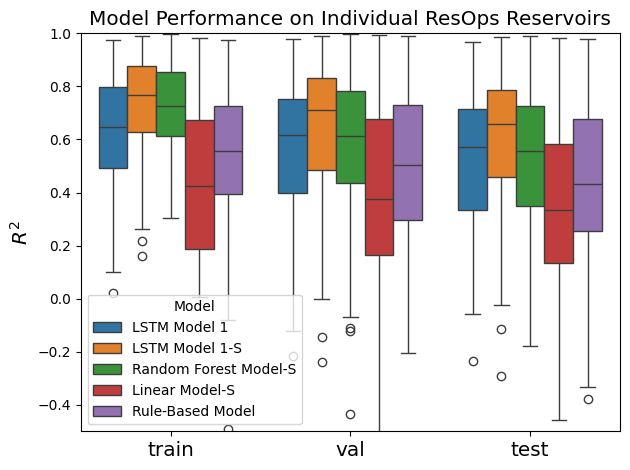

In [5]:
# Plot distribution of performance
fig, ax = plt.subplots()
bp = sns.boxplot(data=r2_scores_benchmark, x='variable', y='value', hue='Model')
ax.set_title('Model Performance on Individual ResOps Reservoirs', size='x-large')
ax.set_ylabel('$R^2$', size='x-large')
ax.set_xlabel('')
plt.setp(ax.get_xticklabels(), size='x-large')
plt.ylim(-0.5, 1)
plt.tight_layout()
plt.savefig('report/drafting/8_15_2025/Figures/individual_resops.png', dpi=300)
plt.show()

For LSTM (no storage) is a large variability in performance, and unsurprisingly, the median performance is decreasing over train, validation, and test.

## Is performance related to the degree of regulation?
Plot performance against reservoir mean(inflow) / max(storage) as well as std(inflow) / std(outflow)

In [6]:
# Read inflow/outflow/storage for all ResOps reservoirs
df_inflow = pd.read_csv("data/ResOpsUS/time_series_single_variable_table/DAILY_AV_INFLOW_CUMECS.csv", 
                        parse_dates=True, index_col=0, dtype=np.float32)
df_outflow = pd.read_csv("data/ResOpsUS/time_series_single_variable_table/DAILY_AV_OUTFLOW_CUMECS.csv", 
                         parse_dates=True, index_col=0, dtype=np.float32)
df_storage = pd.read_csv("data/ResOpsUS/time_series_single_variable_table/DAILY_AV_STORAGE_MCM.csv", 
                         parse_dates=True, index_col=0, dtype=np.float32)

In [7]:
def get_peak_volume(array, threshold=2):
    """ 
    For given reservoir, calculate volume of peak inflow or release
    Params:
    array - timeseries of reservoir inflow/outflow, daily average in m3/s
    threshold - number of standard deviations above the mean to define a peak
    Return:
    peak volume in millions of m3 (MCM)
    """
    sec_to_day = 60 * 60 * 12
    # Get boolean array if day is a peak
    peak_bool = (stats.zscore(array, nan_policy='omit') > threshold)
    # Select peak release days, convert from m3/s to m3/day
    peak_array = array[peak_bool] * sec_to_day
    # Sum to get peak volume, convert to MCM
    return peak_array.sum() / (10^6)

In [8]:
# Calculate mean inflow / max storage metric
df_result = pd.concat([df_inflow.mean(skipna=True), 
                       df_inflow.median(skipna=True),
                       df_inflow.max(),
                       df_inflow.std(skipna=True),
                       df_inflow.apply(get_peak_volume, axis=0),
                       df_outflow.mean(skipna=True),
                       df_outflow.median(skipna=True),
                       df_outflow.max(),
                       df_outflow.std(skipna=True),
                       df_outflow.apply(get_peak_volume, axis=0),
                       df_storage.max()], axis=1, join='inner')
df_result.columns = ['mean_inflow', 'med_inflow', 'max_inflow', 'std_inflow', 'pk_vol_inflow',
                     'mean_outflow', 'med_outflow', 'max_outflow', 'std_outflow', 'pk_vol_outflow',
                     'max_storage']

In [9]:
# Combine with DOR from GRanD
import geopandas as gpd
gdf = gpd.read_file("data/GRanD/GRanD_dams_v1_3.shp").drop(columns="geometry").set_index("GRAND_ID")
gdf.index = gdf.index.astype(str)
df_result = df_result.join(gdf['DOR_PC'], how='left')
df_result['LOG_DOR_PC'] = np.log(df_result['DOR_PC'])

In [10]:
# Combine with model performance
df_result = df_result.join(other=r2_scores_df, how='inner')

In [11]:
# Drop rows with missing and save
df_result = df_result.dropna(axis=0)
df_result.to_csv('report/results/resops_training/resops_attributes_r2.csv')
df_result.head()

,mean_inflow,med_inflow,max_inflow,std_inflow,pk_vol_inflow,mean_outflow,med_outflow,max_outflow,std_outflow,pk_vol_outflow,max_storage,DOR_PC,LOG_DOR_PC,train,val,test
1017,28.196121,14.059000,2980.343018,65.937279,3.409580e+08,28.084494,13.776000,167.834000,29.959730,4.949607e+08,553.226013,61.6,4.120662,0.632672,0.684325,0.628673
1026,124.731316,64.690002,7628.545898,240.312531,1.447851e+09,118.351730,80.844002,2055.346924,134.028549,1.426126e+09,4681.919922,91.5,4.516339,0.650935,0.555938,0.565325
1036,183.351807,113.706001,6513.997070,249.977036,1.711642e+09,174.091354,114.654999,1661.602051,173.091385,1.543661e+09,6802.357910,93.5,4.537961,0.361174,0.344408,0.383323
1042,58.201374,31.658001,5986.455078,123.823402,6.407364e+08,54.375420,39.926998,1588.345947,56.211502,5.266672e+08,2501.490967,120.7,4.793308,0.261352,0.064898,0.088852
1067,50.235088,13.011499,8751.732422,150.883362,8.647316e+08,45.832268,27.466999,303.556000,50.898769,5.107525e+08,3465.172119,297.6,5.695750,0.385523,0.296983,0.466772


In [12]:
def add_usbr_data(df_result):
    """Add Shasta, Trinity, New Melones, Folsom to df_result from USBR data"""
    # Dict to convert USBR name to resops ID
    name_to_id = {'Shasta':'132', 'Folsom':'182', 'New_Melones':'198', 'Trinity':'131'} 

    ## DATA PROCESSING (functions and classes copied from 7_model1_w_storage.ipynb)
    def data_processing(name, transform_type, train_frac=0.6, val_frac=0.2, test_frac=0.2, 
                        left='1944-01-01', right='2022-12-31', log_names=[], 
                        return_scaler=False, storage=True):
        """
        Run data processing pipeline.
        Params:
        name -- str, name of reservoir to read
        transform_type -- str, in preprocessing, whether to 'standardize' or 'normalize' the data
        left -- str (YYYY-MM-DD), beginning boundary of time window
        right -- str (YYYY-MM-DD), end boundary of time window
        log_names -- list of column names (str) to take log of before running rest of pipeline. E.g. ['inflow', 'outflow', 'storage']
        return_scaler -- bool, whether or not to return src.data.data_processing.time_scaler() object
        storage -- bool, whether or not to include storage data in features
        """

        # Read in data, columns are [inflow, outflow, storage]
        df = usbr_fetch_data(name=name, vars=['inflow', 'outflow', 'storage'])
        # Add day of the year (doy) as another column
        df['doy'] = df.index.to_series().dt.dayofyear
        # Select data window
        df = df[left:right].copy()

        # Take log of df columns that are in log_names
        for column_name in df.columns:
            if column_name in log_names:
                df[column_name] = np.log(df[column_name])
            else:
                continue

        # Run data processing pipeline
        pipeline = processing_pipeline(train_frac=train_frac, val_frac=val_frac, test_frac=test_frac, 
                                       chunk_size=3*365, pad_value=-1, 
                                       transform_type=transform_type, fill_na_method='mean')
        # Train/val/test tensors of shape (#chunks, chunksize, [inflow, outflow, storage, doy])
        ts_train, ts_val, ts_test = pipeline.process_data(df) 

        # Separate inputs(X) and targets (y)
        # select inflow, STORAGE, and doy as input features
        if storage:
            X_train, X_val, X_test = ts_train[:, :, [0, 2, 3]], ts_val[:, :, [0, 2, 3]], ts_test[:, :, [0, 2, 3]]
        else:
            X_train, X_val, X_test = ts_train[:, :, [0, 3]], ts_val[:, :, [0, 3]], ts_test[:, :, [0, 3]]
        # select outflow as target feature
        y_train, y_val, y_test = ts_train[:, :, [1]], ts_val[:, :, [1]], ts_test[:, :, [1]]

        if return_scaler:
            return (X_train, y_train), (X_val, y_val), (X_test, y_test), pipeline.scaler, df
        else:
            return (X_train, y_train), (X_val, y_val), (X_test, y_test)
    
    class multi_reservoir_data:
        """Store data from multiple reservoirs"""
        def __init__(self, left_years_dict, storage=True):
            """ 
            Params:
            left_years_dict: dict, dictionary of year of first available data from each requested reservoir (name : year)
            storage: whether or not to include storage in features
            """
            self.left_years_dict = left_years_dict
            self.storage = storage

            # Collect train, val, test tensors from each reservoir and their respective src.data.data_processing.time_scaler() objects
            self.X_train_dict = {}
            self.y_train_dict = {}
            self.X_val_dict = {}
            self.y_val_dict = {}
            self.X_test_dict = {}
            self.y_test_dict = {}
            self.scaler_dict = {}
            self.df_dict = {}
            return
        
        def fetch_data(self):
            """Fetch data for each reservoir and process them into train/val/test tesors"""
            # Run data processing for each reservoir
            for reservoir, left_year in self.left_years_dict.items():
                result = data_processing(name=reservoir, transform_type='standardize', train_frac=0.6, val_frac=0.2, test_frac=0.2,
                                        left=f'{left_year}-01-01', right='2022-12-31',
                                        return_scaler=True, storage=self.storage)
                # Save results
                self.X_train_dict[reservoir] = result[0][0] # (# chunks, chunk size, # features (e.g. inflow and doy))
                self.y_train_dict[reservoir] = result[0][1] # (# chunks, chunk size, 1 (outflow))
                self.X_val_dict[reservoir] = result[1][0]
                self.y_val_dict[reservoir] = result[1][1]
                self.X_test_dict[reservoir] = result[2][0]
                self.y_test_dict[reservoir] = result[2][1]
                self.scaler_dict[reservoir] = result[3]
                self.df_dict[reservoir] = result[4]
            return
        
        def combine_reservoir_data(self):
            """ 
            Concatenate all fetched reservoir data into one train, val, test tensor
            """
            # Concat tensors along chunks dimension (dim = 0)
            X_train, y_train = torch.cat([self.X_train_dict[key] for key in self.left_years_dict], dim=0), torch.cat([self.y_train_dict[key] for key in self.left_years_dict], dim=0)
            X_val, y_val = torch.cat([self.X_val_dict[key] for key in self.left_years_dict], dim=0), torch.cat([self.y_val_dict[key] for key in self.left_years_dict], dim=0)
            X_test, y_test = torch.cat([self.X_test_dict[key] for key in self.left_years_dict], dim=0), torch.cat([self.y_test_dict[key] for key in self.left_years_dict], dim=0)

            return (X_train, y_train), (X_val, y_val), (X_test, y_test)
        
        def fetch_and_combine(self):
            """Run fetch_data and return combined tensors"""
            self.fetch_data()
            return self.combine_reservoir_data()
        
    # Store first available years for each reservoir (1980 for each to match USBR data)
    left_years_dict = {'Shasta':1980, 'Folsom':1980, 'New_Melones':1980, 'Trinity':1980}
    # Combine data from reservoirs (no storage)
    data_collector = multi_reservoir_data(left_years_dict=left_years_dict, storage=False)
    _ = data_collector.fetch_and_combine()

    ## TRAIN LSTM MODEL ON TRUNCATED DATA
    # Model 1a archeticture
    input_size = 2 # inflow, doy
    hidden_size1 = 30
    hidden_size2 = 15
    output_size = 1 # outflow
    dropout_prob = 0.3
    num_layers = 1
    # Instantiate models
    model_dict = {}
    for reservoir_key in left_years_dict:
        torch.manual_seed(0)
        model_dict[reservoir_key] = LSTMModel1_opt(input_size=input_size, hidden_size1=hidden_size1, 
                                                hidden_size2=hidden_size2, output_size=output_size, 
                                                num_layers=num_layers, dropout_prob=dropout_prob)
    # Save training/validation losses for each model
    losses_dict = {}
    # Run training loop for each model
    for reservoir_key in left_years_dict:
        # Create PyTorch Dataset and Dataloader for each reservoir
        dataset_train_res, dataset_val_res = (TensorDataset(data_collector.X_train_dict[reservoir_key], 
                                                            data_collector.y_train_dict[reservoir_key]), 
                                            TensorDataset(data_collector.X_val_dict[reservoir_key], 
                                                            data_collector.y_val_dict[reservoir_key]))
        dataloader_train_res, dataloader_val_res = (DataLoader(dataset_train_res, batch_size=1, shuffle=False), 
                                                    DataLoader(dataset_val_res, batch_size=1, shuffle=False))
        torch.manual_seed(0)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model_dict[reservoir_key].parameters(), lr=0.001)
        # Run training loop 
        train_losses_res, val_losses_res = training_loop(model=model_dict[reservoir_key], criterion=criterion, optimizer=optimizer, 
                                                patience=10, dataloader_train=dataloader_train_res, 
                                                dataloader_val=dataloader_val_res, epochs=1000)
        losses_dict[reservoir_key] = (train_losses_res, val_losses_res)

    ## EVALAUTE LSTM MODEL ON TRUNCATED DATA
    r2_dict = {} # save r2 metrics
    for i, reservoir_key in enumerate(left_years_dict):
        reservoir_left_year = left_years_dict[reservoir_key] # left year window for each reservoir
        # evaluate and model for reservoir
        r2_metrics = eval_train_val_test(model=model_dict[reservoir_key], 
                        X_train=data_collector.X_train_dict[reservoir_key], X_val=data_collector.X_val_dict[reservoir_key], X_test=data_collector.X_test_dict[reservoir_key],
                        y_train=data_collector.y_train_dict[reservoir_key], y_val=data_collector.y_val_dict[reservoir_key], y_test=data_collector.y_test_dict[reservoir_key])
        # save r2 metrics for reservoir
        r2_dict[reservoir_key] = r2_metrics

    ## ADD RESULTS TO results_df
    for reservoir_key in left_years_dict:
        df =  data_collector.df_dict[reservoir_key]
        cf_to_m3 = 0.3048 ** 3 # Cubic feet to cubic meters
        af_to_mcm = 1233.48 / (10 ** 6) # Acre foot to millions of cubic meters
        # Change units to match resops dataset
        df[['inflow', 'outflow']] = df[['inflow', 'outflow']] * cf_to_m3 # cfs to m3/s
        df['storage'] = df['storage'] * af_to_mcm # af to millions of cubic meters
        reservoir_series = pd.Series([df.inflow.mean(skipna=True), 
                    df.inflow.median(skipna=True),
                    df.inflow.max(),
                    df.inflow.std(skipna=True),
                    get_peak_volume(df.inflow),
                    df.outflow.mean(skipna=True),
                    df.outflow.median(skipna=True),
                    df.outflow.max(),
                    df.outflow.std(skipna=True),
                    get_peak_volume(df.outflow),
                    df.storage.max(),
                    gdf.loc[name_to_id[reservoir_key], 'DOR_PC'],
                    np.log(gdf.loc[name_to_id[reservoir_key], 'DOR_PC']),
                    r2_dict[reservoir_key][0],
                    r2_dict[reservoir_key][1],
                    r2_dict[reservoir_key][2]], dtype=np.float32)
        reservoir_series.index = ['mean_inflow', 'med_inflow', 'max_inflow', 'std_inflow', 'pk_vol_inflow',
                            'mean_outflow', 'med_outflow', 'max_outflow', 'std_outflow', 'pk_vol_outflow',
                            'max_storage', 'DOR_PC', 'LOG_DOR_PC', 'train', 'val', 'test']
        df_result.loc[name_to_id[reservoir_key], :] = reservoir_series

    return

In [13]:
def lobf(x, y, ax):
    """Plot line of best fit"""
    #Find line of best fit
    a, b = np.polyfit(x, y, 1)
    #Add line of best fit to plot
    ax.plot(x, a*x+b, color='red')
    return

In [14]:
def correlate(x, y):
    """Return pearson correlation"""
    return stats.pearsonr(x, y)[0]

In [15]:
def correlate_pval(x, y, alt='two-sided', n_resamples=10000):
    """
    Return pval testing significance of correlation coefficient using permutation testing
    Params:
    x, y: data arrays to calculate correlation between
    alt: str, 'greater', 'less', or 'two-sided'. The alternative hypothesis
    n_resamples: int, number of permutations used to approximate null distribution
    Return:
    r - float, Pearson's correlation between x and y
    pvalue - p-value from permutation testing
    """
    # Calculate correlation between x and y and permuation test p-value
    res = stats.permutation_test((x, y), correlate, vectorized=False,
                        permutation_type='pairings',
                        alternative=alt,
                        n_resamples=n_resamples,
                        random_state=0)
    r, pvalue, null = res.statistic, res.pvalue, res.null_distribution
    return r, pvalue

In [16]:
# Add usbr data to result_df
add_usbr_data(df_result=df_result)

Training epochs:   9%|▊         | 87/1000 [00:02<00:31, 29.05it/s]


c:\Users\mattc\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_resampling.py:1498: RuntimeWarning: overflow encountered in scalar power
  n_max = factorial(n_obs_sample)**n_samples


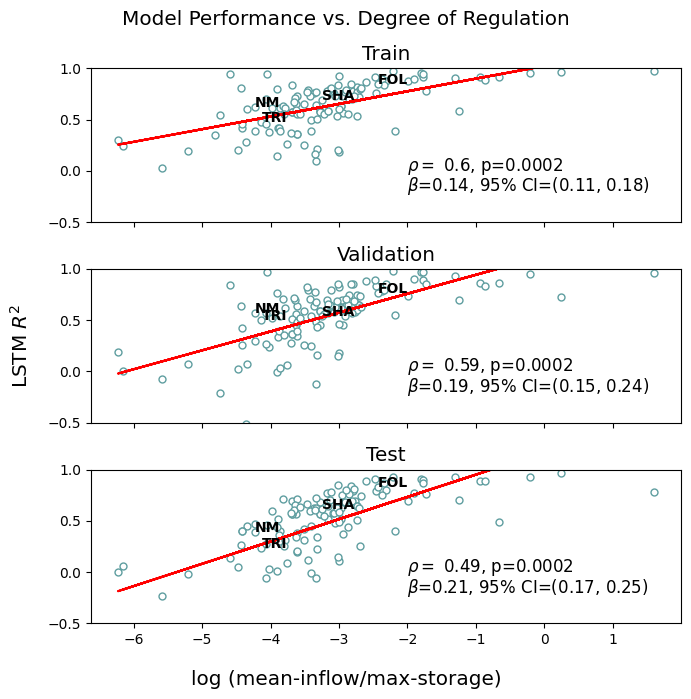

In [34]:
# Plot result
fig, axes = plt.subplots(nrows=3, figsize=(7, 7), sharex=True, sharey=True)
# log(mean inflow / max storage) ratio
# max storage is surrogate for capacity
x = np.log(df_result['mean_inflow'] / df_result['max_storage'])
# LSTM R2 performance
y_train, y_val, y_test = df_result['train'], df_result['val'], df_result['test']

axes[0].scatter(x, y_train, s=25, color='white', edgecolors='cadetblue')
# Label Shasta, New Melones, Trinity, Folsom
name_to_id = {'SHA':'132', 'FOL':'182', 'NM':'198', 'TRI':'131'} # reservoir name to reservoir ID

for name, id in name_to_id.items():
    axes[0].text(x[id], y_train[id], name, weight='bold')
axes[0].set_ylim(-0.5, 1)
axes[0].set_title('Train', size='x-large')
# Add line of best fit
lobf(x, y_train, ax=axes[0]) 
# Add correlation and p-value
corr_train, pval_train = correlate_pval(x, y_train)
axes[0].text(-2, 0, r'$\rho=$'+f' {round(corr_train, 2)}, p={round(pval_train, 6)}', size='large')
# Theil-Sen slope and 95 CI
slope_train, intercept_train, lo_train, hi_train = theilslopes(y_train, x, alpha=0.95)
axes[0].text(-2, -0.2, fr'$\beta$={round(slope_train, 2)}, 95% CI=({round(lo_train, 2)}, {round(hi_train, 2)})', size='large')

axes[1].scatter(x, y_val, s=25, color='white', edgecolors='cadetblue')
for name, id in name_to_id.items():
    axes[1].text(x[id], y_val[id], name, weight='bold')
axes[1].set_ylim(-0.5, 1)
axes[1].set_title('Validation', size='x-large')
lobf(x, y_val, ax=axes[1])
corr_val, pval_val = correlate_pval(x, y_val)
axes[1].text(-2, 0, r'$\rho=$'+f' {round(corr_val, 2)}, p={round(pval_val, 6)}', size='large')
# Theil-Sen slope and 95 CI
slope_val, intercept_val, lo_val, hi_val = theilslopes(y_val, x, alpha=0.95)
axes[1].text(-2, -0.2, fr'$\beta$={round(slope_val, 2)}, 95% CI=({round(lo_val, 2)}, {round(hi_val, 2)})', size='large')

# One outlying point is removed from the test set
axes[2].scatter(x.drop(index='1249'), y_test.drop(index='1249'), s=25, color='white', edgecolors='cadetblue')
for name, id in name_to_id.items():
    axes[2].text(x[id], y_test[id], name, weight='bold')
axes[2].set_ylim(-0.5, 1)
axes[2].set_title('Test', size='x-large')
lobf(x.drop(index='1249'), y_test.drop(index='1249'), ax=axes[2])
corr_test, pval_test = correlate_pval(x.drop(index='1249'), y_test.drop(index='1249'))
axes[2].text(-2, 0, r'$\rho=$'+f' {round(corr_test, 2)}, p={round(pval_test, 6)}', size='large')
# Theil-Sen slope and 95 CI
slope_test, intercept_test, lo_test, hi_test = theilslopes(y_test, x, alpha=0.95)
axes[2].text(-2, -0.2, fr'$\beta$={round(slope_test, 2)}, 95% CI=({round(lo_test, 2)}, {round(hi_test, 2)})', size='large')

fig.suptitle('Model Performance vs. Degree of Regulation', size='x-large')
fig.supylabel('LSTM $R^2$', size='x-large')
fig.supxlabel('log (mean-inflow/max-storage)', size='x-large')
plt.tight_layout()
plt.savefig('report/drafting/8_15_2025/Figures/degree_of_regulation1.png', dpi=300)
plt.show()

c:\Users\mattc\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_resampling.py:1498: RuntimeWarning: overflow encountered in scalar power
  n_max = factorial(n_obs_sample)**n_samples


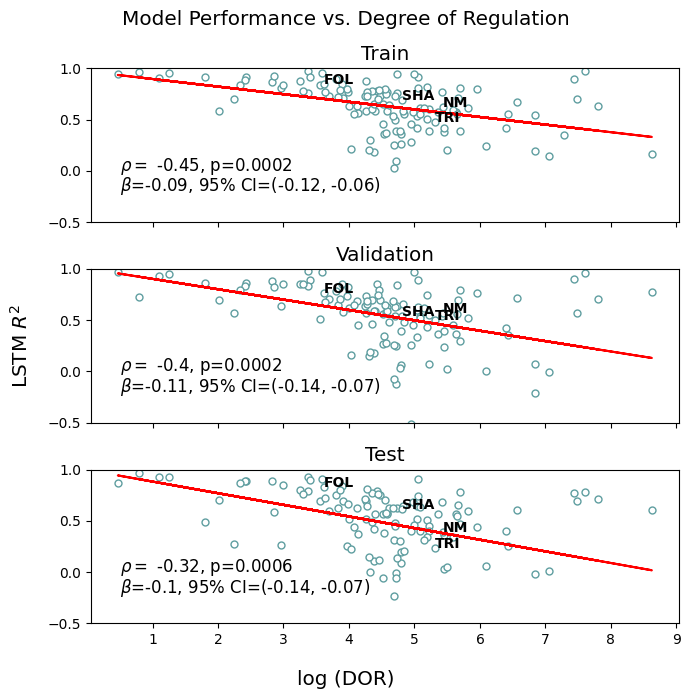

In [35]:
# Plot result
fig, axes = plt.subplots(nrows=3, figsize=(7, 7), sharex=True, sharey=True)
# log(mean inflow / max storage) ratio
# max storage is surrogate for capacity
x = df_result['LOG_DOR_PC']
# LSTM R2 performance
y_train, y_val, y_test = df_result['train'], df_result['val'], df_result['test']

axes[0].scatter(x, y_train, s=25, color='white', edgecolors='cadetblue')
# Label Shasta, New Melones, Trinity, Folsom
name_to_id = {'SHA':'132', 'FOL':'182', 'NM':'198', 'TRI':'131'} # reservoir name to reservoir ID

for name, id in name_to_id.items():
    axes[0].text(x[id], y_train[id], name, weight='bold')
axes[0].set_ylim(-0.5, 1)
axes[0].set_title('Train', size='x-large')
# Add line of best fit
lobf(x, y_train, ax=axes[0]) 
# Add correlation and p-value
corr_train, pval_train = correlate_pval(x, y_train)
axes[0].text(0.5, 0, r'$\rho=$'+f' {round(corr_train, 2)}, p={round(pval_train, 6)}', size='large')
# Theil-Sen slope and 95 CI
slope_train, intercept_train, lo_train, hi_train = theilslopes(y_train, x, alpha=0.95)
axes[0].text(0.5, -0.2, fr'$\beta$={round(slope_train, 2)}, 95% CI=({round(lo_train, 2)}, {round(hi_train, 2)})', size='large')

axes[1].scatter(x, y_val, s=25, color='white', edgecolors='cadetblue')
for name, id in name_to_id.items():
    axes[1].text(x[id], y_val[id], name, weight='bold')
axes[1].set_ylim(-0.5, 1)
axes[1].set_title('Validation', size='x-large')
lobf(x, y_val, ax=axes[1])
corr_val, pval_val = correlate_pval(x, y_val)
axes[1].text(0.5, 0, r'$\rho=$'+f' {round(corr_val, 2)}, p={round(pval_val, 6)}', size='large')
# Theil-Sen slope and 95 CI
slope_val, intercept_val, lo_val, hi_val = theilslopes(y_val, x, alpha=0.95)
axes[1].text(0.5, -0.2, fr'$\beta$={round(slope_val, 2)}, 95% CI=({round(lo_val, 2)}, {round(hi_val, 2)})', size='large')

# One outlying point is removed from the test set
axes[2].scatter(x.drop(index='1249'), y_test.drop(index='1249'), s=25, color='white', edgecolors='cadetblue')
for name, id in name_to_id.items():
    axes[2].text(x[id], y_test[id], name, weight='bold')
axes[2].set_ylim(-0.5, 1)
axes[2].set_title('Test', size='x-large')
lobf(x.drop(index='1249'), y_test.drop(index='1249'), ax=axes[2])
corr_test, pval_test = correlate_pval(x.drop(index='1249'), y_test.drop(index='1249'))
axes[2].text(0.5, 0, r'$\rho=$'+f' {round(corr_test, 2)}, p={round(pval_test, 6)}', size='large')
# Theil-Sen slope and 95 CI
slope_test, intercept_test, lo_test, hi_test = theilslopes(y_test, x, alpha=0.95)
axes[2].text(0.5, -0.2, fr'$\beta$={round(slope_test, 2)}, 95% CI=({round(lo_test, 2)}, {round(hi_test, 2)})', size='large')

fig.suptitle('Model Performance vs. Degree of Regulation', size='x-large')
fig.supylabel('LSTM $R^2$', size='x-large')
fig.supxlabel('log (DOR)', size='x-large')
plt.tight_layout()
plt.savefig('report/drafting/8_15_2025/Figures/degree_of_regulation2.png', dpi=300)
plt.show()

c:\Users\mattc\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_resampling.py:1498: RuntimeWarning: overflow encountered in scalar power
  n_max = factorial(n_obs_sample)**n_samples


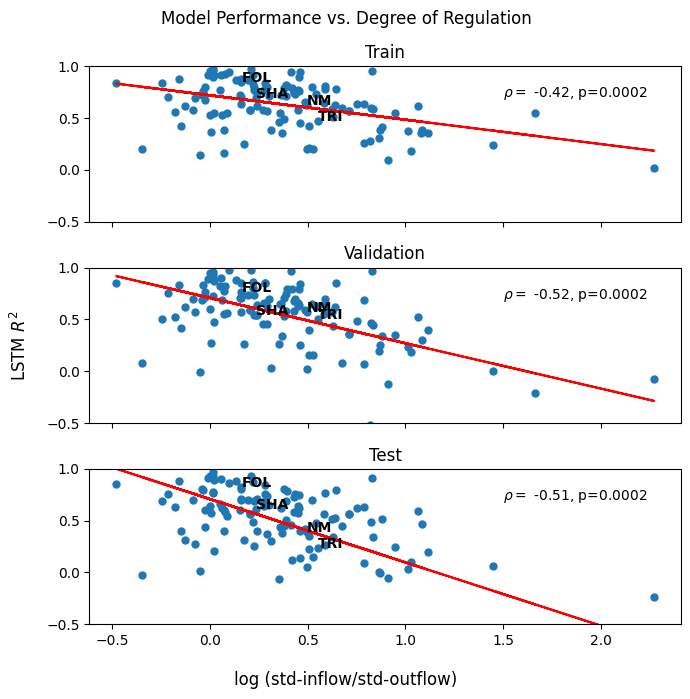

In [18]:
# Plot result
fig, axes = plt.subplots(nrows=3, figsize=(7, 7), sharex=True, sharey=True)
x = np.log(df_result['std_inflow'] / df_result['std_outflow'])
# LSTM R2 performance
y_train, y_val, y_test = df_result['train'], df_result['val'], df_result['test']

axes[0].scatter(x, y_train, s=25)
for name, id in name_to_id.items():
    axes[0].text(x[id], y_train[id], name, weight='bold')
axes[0].set_ylim(-0.5, 1)
axes[0].set_title('Train')
lobf(x, y_train, ax=axes[0]) # add line of best fit
# Add correlation and p-value
corr_train, pval_train = correlate_pval(x, y_train)
axes[0].text(1.5, 0.7, r'$\rho=$'+f' {round(corr_train, 2)}, p={round(pval_train, 6)}')

axes[1].scatter(x, y_val, s=25)
for name, id in name_to_id.items():
    axes[1].text(x[id], y_val[id], name, weight='bold')
axes[1].set_ylim(-0.5, 1)
axes[1].set_title('Validation')
lobf(x, y_val, ax=axes[1])
corr_val, pval_val = correlate_pval(x, y_val)
axes[1].text(1.5, 0.7, r'$\rho=$'+f' {round(corr_val, 2)}, p={round(pval_val, 6)}')

# One outlying point is removed from the test set
axes[2].scatter(x.drop(index='1249'), y_test.drop(index='1249'), s=25)
for name, id in name_to_id.items():
    axes[2].text(x[id], y_test[id], name, weight='bold')
axes[2].set_ylim(-0.5, 1)
axes[2].set_title('Test')
lobf(x.drop(index='1249'), y_test.drop(index='1249'), ax=axes[2])
corr_test, pval_test = correlate_pval(x.drop(index='1249'), y_test.drop(index='1249'))
axes[2].text(1.5, 0.7, r'$\rho=$'+f' {round(corr_test, 2)}, p={round(pval_test, 6)}')

fig.suptitle('Model Performance vs. Degree of Regulation')
fig.supylabel('LSTM $R^2$')
fig.supxlabel('log (std-inflow/std-outflow)')
plt.tight_layout()
plt.show()

c:\Users\mattc\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_resampling.py:1498: RuntimeWarning: overflow encountered in scalar power
  n_max = factorial(n_obs_sample)**n_samples


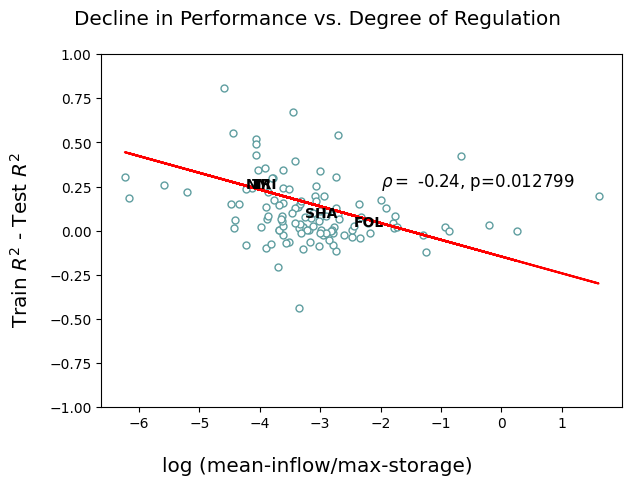

In [19]:
# Plot result
fig, axes = plt.subplots()
x = np.log(df_result['mean_inflow'] / df_result['max_storage'])
# LSTM R2 performance
y = df_result['train'] - df_result['test']

# One outlying point is removed from the test set
axes.scatter(x.drop(index='1249'), y.drop(index='1249'), s=25, color='white', edgecolors='cadetblue')
for name, id in name_to_id.items():
    axes.text(x[id], y[id], name, weight='bold')
lobf(x.drop(index='1249'), y.drop(index='1249'), ax=axes)
corr, pval = correlate_pval(x.drop(index='1249'), y.drop(index='1249'))
axes.text(-2, 0.25, r'$\rho=$'+f' {round(corr, 2)}, p={round(pval, 6)}', size='large')
axes.set_ylim(-1, 1)
fig.suptitle('Decline in Performance vs. Degree of Regulation', size='x-large')
fig.supylabel('Train $R^2$ - Test $R^2$', size='x-large')
fig.supxlabel('log (mean-inflow/max-storage)', size='x-large')
plt.tight_layout()
plt.savefig('report/drafting/8_15_2025/Figures/r2_decline_dor.png', dpi=300)

plt.show()

We find that the correlation between log(inflow/storage) and LSTM model performance (R2) is strong for training and validation, approximately r=0.6. The correlation coefficient is weaker in the test set, but as discussed more factors affect model performance further into the future such as changing reservoir policy. Additionally, at the level 0.05, the permutation test shows that each correlation is significantly greater than 0.

These results support the hypothesis that the degree of regulation adversely affects model performance.

## Is performance related to geographic region?
Plot performance of LSTM geographically

In [20]:
# Fetch GPS coordinates of reservoirs
coords_all = pd.read_csv('data/ResOpsUS/attributes/reservoir_attributes.csv', index_col=0)[['LONG', 'LAT']]
coords_all.index = coords_all.index.astype(str) # str index consistent with rest of experiment
coords_all

,LONG,LAT
DAM_ID,,
41,-121.067305,48.732466
42,-121.130320,48.714583
54,-123.604561,47.386357
55,-121.340171,47.323654
56,-121.783969,47.277406
...,...,...
1868,-88.519826,33.832243
1876,-88.488172,33.519852
1908,-88.792326,32.474874


In [21]:
# Join with LSTM performance dataframe
coords_all = coords_all.join(other=df_result[['train', 'val', 'test']], how='inner')
coords_all

,LONG,LAT,train,val,test
55,-121.340171,47.323654,0.531267,0.686194,0.619795
57,-121.205208,47.265956,0.558612,0.521297,0.631102
60,-121.302083,46.868750,0.778935,0.848356,0.760177
63,-121.128322,46.654792,0.703121,0.750312,0.757915
131,-122.760687,40.802949,0.474738,0.501355,0.233209
...,...,...,...,...,...
1864,-89.904470,34.151653,0.099003,-0.122187,-0.054671
1869,-89.768740,33.814591,0.355154,0.398757,0.199755
1883,-83.157149,33.352754,0.956038,0.968840,0.909732
7313,-111.727374,46.648333,0.791577,0.708377,0.804213


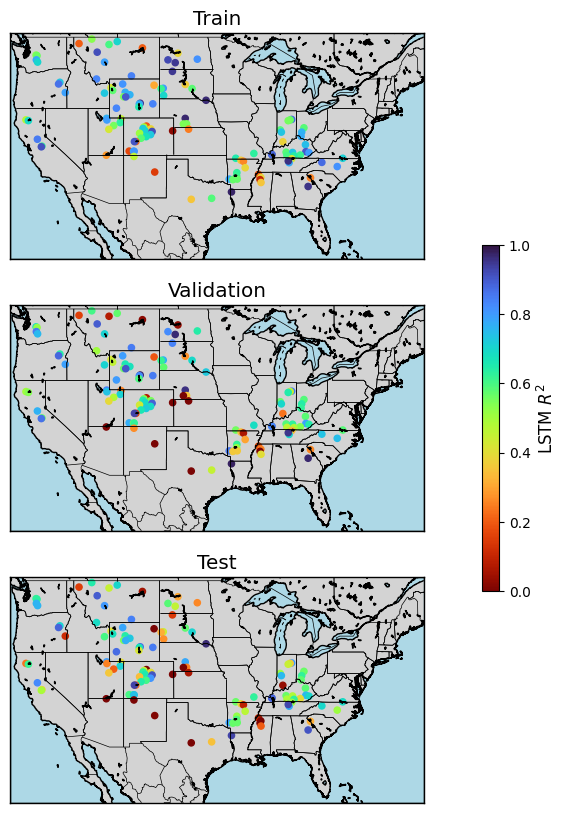

In [22]:
# Set up map
fig, axes = plt.subplots(nrows=3, figsize=(15, 10))
map1 = Basemap(projection='merc', llcrnrlat=24.396308, urcrnrlat=49.384358,
              llcrnrlon=-125.001650, urcrnrlon=-66.934570, resolution='i', ax=axes[0])
map1.drawcoastlines()
map1.drawcountries()
map1.drawstates()
map1.fillcontinents(color='lightgrey', lake_color='lightblue')
map1.drawmapboundary(fill_color='lightblue')

map2 = Basemap(projection='merc', llcrnrlat=24.396308, urcrnrlat=49.384358,
              llcrnrlon=-125.001650, urcrnrlon=-66.934570, resolution='i', ax=axes[1])
map2.drawcoastlines()
map2.drawcountries()
map2.drawstates()
map2.fillcontinents(color='lightgrey', lake_color='lightblue')
map2.drawmapboundary(fill_color='lightblue')

map3 = Basemap(projection='merc', llcrnrlat=24.396308, urcrnrlat=49.384358,
              llcrnrlon=-125.001650, urcrnrlon=-66.934570, resolution='i', ax=axes[2])
map3.drawcoastlines()
map3.drawcountries()
map3.drawstates()
map3.fillcontinents(color='lightgrey', lake_color='lightblue')
map3.drawmapboundary(fill_color='lightblue')

# Convert lat/long to map projection coordinates
x, y = map1(coords_all['LONG'], coords_all['LAT'])

# Scatter plot with color coding
sc_train = map1.scatter(x, y, c=coords_all['train'], 
                       vmin=0, vmax=1, cmap='turbo_r', s=20, ax=axes[0])
axes[0].set_title('Train', size='x-large')

sc_val = map2.scatter(x, y, c=coords_all['val'], 
                       vmin=0, vmax=1, cmap='turbo_r', s=20, ax=axes[1])
axes[1].set_title('Validation', size='x-large')

sc_test = map3.scatter(x, y, c=coords_all['test'], 
                       vmin=0, vmax=1, cmap='turbo_r', s=20, ax=axes[2])
axes[2].set_title('Test', size='x-large')

# Add a colorbar
cbar = plt.colorbar(sc_train, ax=[axes[0], axes[1], axes[2]],
            orientation='vertical', shrink=0.45)
cbar.set_label('LSTM $R^2$', size='large')

# Show the plot
plt.savefig('report/drafting/8_15_2025/Figures/performance_map.png', dpi=300)
plt.show()

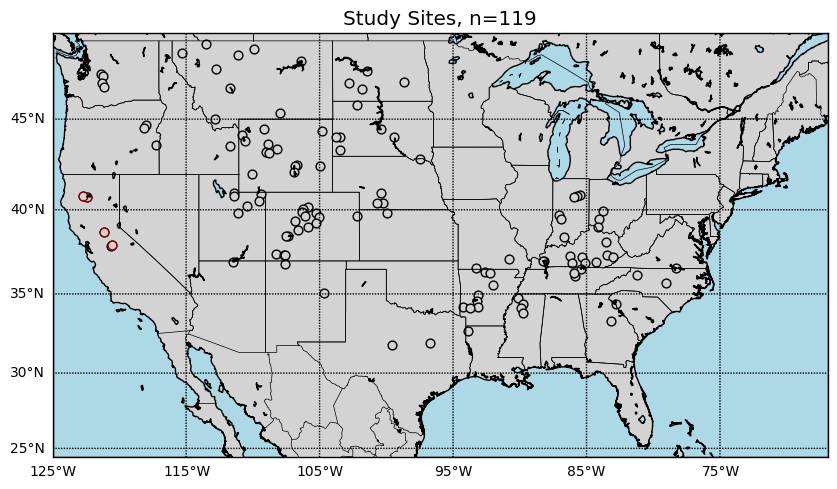

In [24]:
# Create plain map showing locations of reservoirs (USBR data highlighted in red)
# Set up map
fig, axes = plt.subplots(figsize=(10, 7))
map = Basemap(projection='merc', llcrnrlat=24.396308, urcrnrlat=49.384358,
              llcrnrlon=-125.001650, urcrnrlon=-66.934570, resolution='i', ax=axes)
map.drawcoastlines()
map.drawcountries()
map.drawstates()
map.fillcontinents(color='lightgrey', lake_color='lightblue')
map.drawmapboundary(fill_color='lightblue')

# Add parallels (latitude lines) and meridians (longitude lines)
map.drawparallels(range(25, 51, 5), labels=[1, 0, 0, 0], fontsize=10)
map.drawmeridians(range(-125, -64, 10), labels=[0, 0, 0, 1], fontsize=10)

# Convert lat/long to map projection coordinates
usbr_ids = [id_item for res_key, id_item in name_to_id.items()] # reservoir ID's for USBR reservoirs
x, y = map(coords_all['LONG'], coords_all['LAT'])
x_usbr, y_usbr = map(coords_all.loc[usbr_ids, 'LONG'], coords_all.loc[usbr_ids, 'LAT'])

# Scatter plot 
sc = map.scatter(x, y, c='lightgrey', s=40, ax=axes, edgecolors='black')
sc = map.scatter(x_usbr, y_usbr, s=40, c='lightgrey', ax=axes, edgecolors='darkred')
axes.set_title('Study Sites, n=119', size='x-large')

plt.savefig('report/drafting/8_15_2025/Figures/study_sites_map.png', dpi=300)
plt.show()

# Evaluate Performance in Simulatneous (Pooled) Training

## Performance in out-of-sample reservoirs
A simulatenous pooled training model was trained on 80% of randomly selected reservoirs (in-sample reservoirs) and tested against the remaining 20% reservoirs (out-of-sample reservoirs). For in-sample reservoirs, training is done using a 75% training and 25% validation split (for early stopping)

In [36]:
# Read data
in_sample_r2 = pd.read_csv('report/results/resops_training/resops_oos_in_sample_train_val.csv', index_col=0)
out_of_sample_r2 = pd.read_csv('report/results/resops_training/resops_oos_out_of_sample_test.csv', index_col=0)

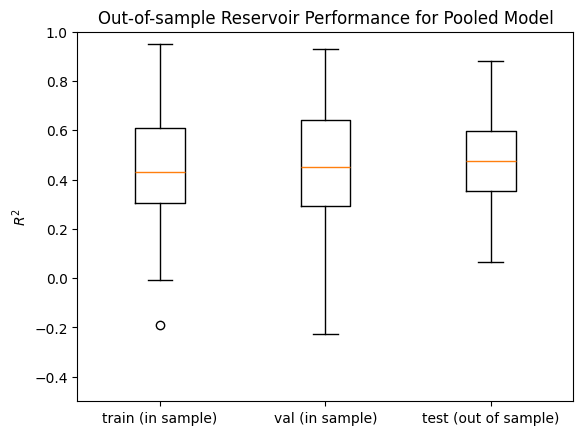

In [37]:
fig, ax = plt.subplots()
ax.boxplot([in_sample_r2['train'], 
            in_sample_r2['val'],
            out_of_sample_r2.values.flatten()], tick_labels=['train (in sample)',
                                       'val (in sample)',
                                       'test (out of sample)'])
ax.set_ylim(-0.5, 1)
ax.set_title('Out-of-sample Reservoir Performance for Pooled Model')
ax.set_ylabel('$R^2$')
plt.show()

Distribution of out-of-sample reservoir performance after pooled training is noticeably worse than out-of-time performance in individual training.

## Finetuning performance
The multi-reservoir reservoir model is then fine-tuned using the first n years of the record (training 75%, validation 25% of those n year) and tested using the last 20% of the complete record (same as the test set for individual training experiments). These finetuned models are then compared to individual training and to the multi-reservoir model with no finetuning.

In [38]:
# Read data
finetuning_r2 = pd.read_csv('report/results/resops_training/resops_oos_finetuning.csv', index_col=0)
finetuning_r2.head()

,individual,pooled,finetuned_pooled_5yr,finetuned_pooled_10yr,finetuned_pooled_15yr,finetuned_pooled_20yr,finetuned_pooled_25yr,finetuned_pooled_30yr
1869,0.199755,-0.165452,-0.128551,0.032408,0.107563,0.163784,0.205877,0.183620
895,0.965952,0.823780,0.889596,0.966612,0.954449,0.952301,0.959942,0.965132
893,0.270567,0.178756,0.143408,0.166901,0.312319,0.176384,0.234717,0.216997
319,0.898371,0.850601,0.863798,0.878576,0.864737,0.879513,0.888954,0.890156
780,0.261094,0.252179,0.211346,0.226846,0.210564,0.217350,0.269416,0.269658


In [39]:
finetuning_r2.median()

individual               0.565325
pooled                   0.399307
finetuned_pooled_5yr     0.482440
finetuned_pooled_10yr    0.479424
finetuned_pooled_15yr    0.514125
finetuned_pooled_20yr    0.498639
finetuned_pooled_25yr    0.512486
finetuned_pooled_30yr    0.565346
dtype: float64

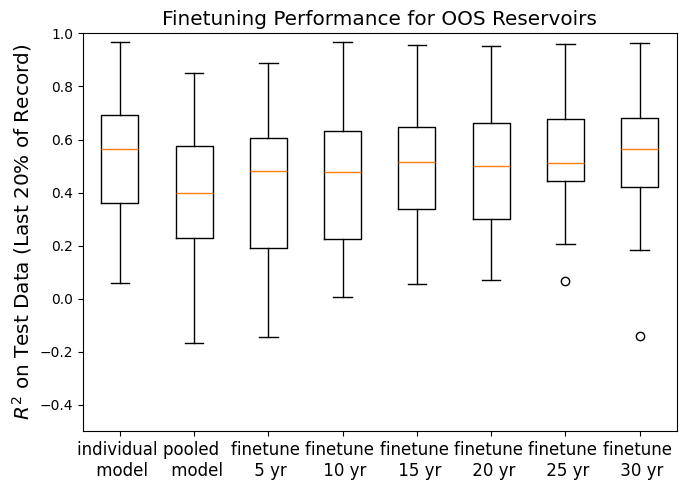

In [40]:
fig, ax = plt.subplots(figsize=(7, 5))
# Create boxplot
bp = ax.boxplot(finetuning_r2, tick_labels=['individual \n model',
                                  'pooled \n model',
                                  'finetune \n 5 yr',
                                  'finetune \n 10 yr',
                                  'finetune \n 15 yr',
                                  'finetune \n 20 yr',
                                  'finetune \n 25 yr',
                                  'finetune \n 30 yr'])

ax.set_ylim(-0.5, 1)
ax.set_title('Finetuning Performance for OOS Reservoirs', size='x-large')
ax.set_ylabel('$R^2$ on Test Data (Last 20% of Record)', size='x-large')
plt.setp(ax.get_xticklabels(), size='large')
plt.tight_layout()
plt.savefig('report/drafting/8_15_2025/Figures/fintetuning_resops.png', dpi=300)
plt.show()

Observations:
1. Finetuning on 5 or 10 years of data does not add much compared to using the pooled model directly
2. Finetuning on 30 years (30 * 75% = 22.5 years training) has lower median than individual training (~40 * 60% = 24)
even though the amount of training data is roughly the same.

These observations provide evidence that finetuning on the pooled model provides little additional knowledge than to train on each reservoir individually.

### Appendix: Outlying Reservoir in Test Set

In [24]:
df_result[df_result['test'] < -20]

,mean_inflow,med_inflow,max_inflow,std_inflow,pk_vol_inflow,mean_outflow,med_outflow,max_outflow,std_outflow,pk_vol_outflow,max_storage,train,val,test
1249,0.126683,0.006,68.357002,1.109484,3.282887e+06,0.040948,0.0,13.535,0.376597,1.170479e+06,15.613,0.351834,-1.655672,-41.940881


Text(-4.9, -40, 'Reservoir 1249')

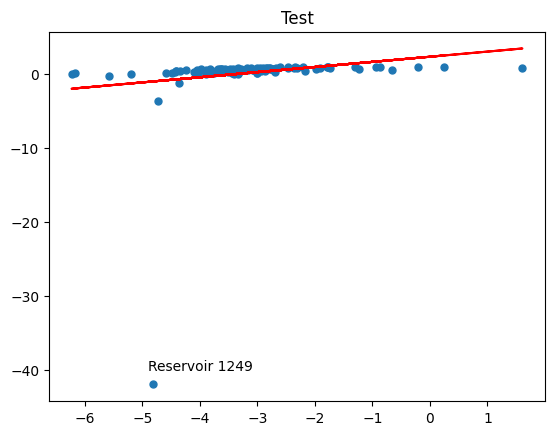

In [25]:
fig, axes = plt.subplots()
axes.scatter(np.log(df_result['mean_inflow'] / df_result['max_storage']), df_result['test'], s=25)
# axes.set_ylim(-0.5, 1)
axes.set_title('Test')
lobf(np.log(df_result['mean_inflow'] / df_result['max_storage']), df_result['test'], ax=axes)
axes.text(-4.9, -40, 'Reservoir 1249')